In [ ]:
## Kết nối Google Drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)
## Thư mục làm việc
folder = '/content/gdrive/My Drive'

Mounted at /content/gdrive


In [ ]:
## Thư viện
import joblib             as jlb
import matplotlib.pyplot  as plt
import numpy              as np
import pandas             as pd
import seaborn            as sbn
import warnings
warnings.filterwarnings('ignore') # tắt những cảnh báo

from collections          import Counter
from sklearn.cluster      import KMeans

Đọc dữ liệu

In [ ]:
customer = pd.read_csv(folder + '/Contoso/DimCustomer.csv')
geography = pd.read_csv(folder + '/Contoso/DimGeography.csv')

In [ ]:
print(customer.head())

   Unnamed: 0  CustomerKey  GeographyKey  FirstName LastName   BirthDate  \
0           0            1           680        Jon     Yang  1966-04-08   
1           1            2           692     Eugene    Huang  1965-05-14   
2           2            3           493      Ruben   Torres  1965-08-12   
3           3            4           519    Christy      Zhu  1968-02-15   
4           4            5           706  Elizabeth  Johnson  1968-08-08   

  MaritalStatus Gender  YearlyIncome  TotalChildren  NumberChildrenAtHome  \
0             M      M       90000.0            2.0                   0.0   
1             S      M       60000.0            3.0                   3.0   
2             M      M       60000.0            3.0                   3.0   
3             S      F       70000.0            0.0                   0.0   
4             S      F       80000.0            5.0                   5.0   

   Education    Occupation  HouseOwnerFlag  NumberCarsOwned  
0  Bachelors  Prof

In [ ]:
print(geography.head())

   GeographyKey   GeographyType  ContinentName CityName StateProvinceName  \
0             1       Continent           Asia      NaN               NaN   
1             2       Continent         Europe      NaN               NaN   
2             3       Continent  North America      NaN               NaN   
3           269  Country/Region           Asia      NaN               NaN   
4           270  Country/Region           Asia      NaN               NaN   

  RegionCountryName  
0               NaN  
1               NaN  
2               NaN  
3           Armenia  
4         Australia  


#Data preporcessing

Drop irrelevant columns

In [ ]:
customer = customer.drop(['Unnamed: 0', 'FirstName', 'LastName', 'BirthDate', 'HouseOwnerFlag', 'NumberCarsOwned'], axis = 1)
geography = geography.drop(['CityName', 'StateProvinceName', 'RegionCountryName', 'GeographyType'], axis = 1)

Merge data

In [ ]:
customer_geo = customer.merge(geography, on='GeographyKey')
customer_geo = customer_geo.drop(['CustomerKey', 'GeographyKey'], axis = 1)

In [ ]:
customer_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18869 entries, 0 to 18868
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MaritalStatus         18869 non-null  object 
 1   Gender                18869 non-null  object 
 2   YearlyIncome          18869 non-null  float64
 3   TotalChildren         18869 non-null  float64
 4   NumberChildrenAtHome  18869 non-null  float64
 5   Education             18869 non-null  object 
 6   Occupation            18869 non-null  object 
 7   ContinentName         18869 non-null  object 
dtypes: float64(3), object(5)
memory usage: 1.2+ MB


Missing values cleaning

In [ ]:
customer_geo.isnull().any()

,0
MaritalStatus,False
Gender,False
YearlyIncome,False
TotalChildren,False
NumberChildrenAtHome,False
Education,False
Occupation,False
ContinentName,False


In [ ]:
customer_geo.isna().any()

,0
MaritalStatus,False
Gender,False
YearlyIncome,False
TotalChildren,False
NumberChildrenAtHome,False
Education,False
Occupation,False
ContinentName,False


Outlier cleaning

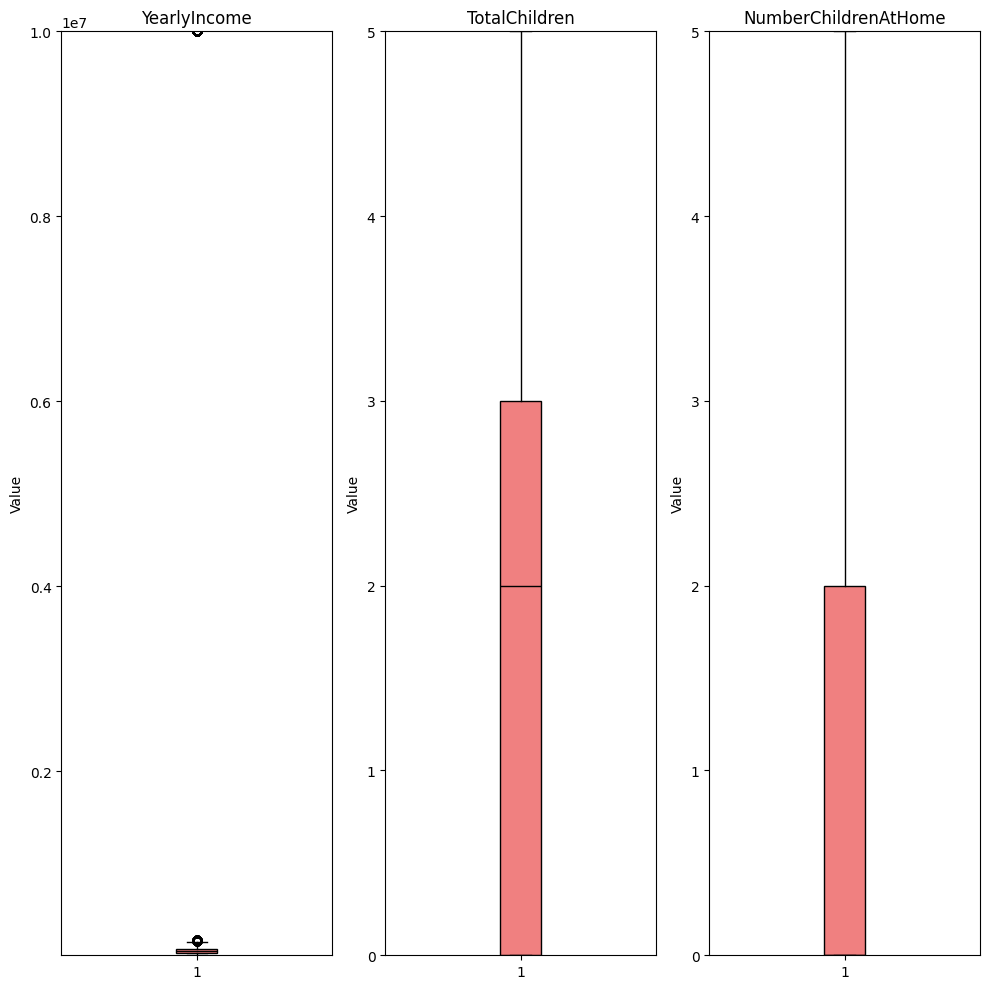

In [ ]:
columns_boxplot = ['YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome']
num_rows = 1
num_cols = 3
#Creating the figure and draw a 5x3-size matrix to store graphs
fig_box, axes_box = plt.subplots(num_rows, num_cols, figsize=(10,10))
#axes is a numpy.array
axes_box = axes_box.flatten() #convert to 1d array

for i, column in enumerate(columns_boxplot):
    axis = axes_box[i]
    box = axis.boxplot(customer_geo[column], patch_artist=True)
    # Fill the boxplot with color
    for patch in box['boxes']:
        patch.set_facecolor('lightcoral')

    # Change colour of the median line
    for median_line in box['medians']:
        median_line.set_color('black')  # Change 'red' to any color you prefer
    axis.set_title(f"{column}")
    axis.set_ylabel('Value')
    axis.set_ylim(customer_geo[column].min(), customer_geo[column].max())

plt.tight_layout() #Preventing an axis from overlapping another axis
plt.show()

In [ ]:
numeric_cols = customer_geo.select_dtypes(include=np.number).columns
#Dropping outliers using z-score
def outliers_cleaning(data: pd.DataFrame, numeric_columns: list) -> pd.DataFrame:
    for column in numeric_columns:
        upper_limit = data[column].mean() + 3*data[column].std()
        lower_limit = data[column].mean() - 3*data[column].std()
        data = data[(data[column] > lower_limit) & (data[column] < upper_limit)]
    return data

customer_geo = outliers_cleaning(customer_geo, numeric_cols)

Encode "MaritalStatus" column

In [ ]:
mapping_maritalstatus = {'M': 1, 'S': 0} ##1: Married, 0: Single
customer_geo['MaritalStatus'] = [mapping_maritalstatus[marital] for marital in customer_geo['MaritalStatus']]

Encode "Gender" column

In [ ]:
mapping_gender = {'F': 0, 'M': 1} ##0: Female, 1: Male
customer_geo['Gender'] = [mapping_gender[sex] for sex in customer_geo['Gender']]

Encode "Education" column

In [ ]:
mapping_edu = {'Partial High School': 1, 'High School': 2, 'Partial College': 3, 'Bachelors': 4, 'Graduate Degree': 5}
customer_geo['Education'] = [mapping_edu[edu] for edu in customer_geo['Education']]

Encode "Operation" column

In [ ]:
onehot_occupation = pd.get_dummies(customer_geo['Occupation'], dtype=np.int64)
customer_geo = pd.concat([customer_geo, onehot_occupation], axis = 1)
#Drop 'Occupation" column
customer_geo = customer_geo.drop('Occupation', axis = 1)

Encode "GeographyType" column

In [ ]:
# customer_geo['GeographyType'].unique() ##Has only 1 value, not helping for segmentation, this column will be dropped


Encode "ContinentName" column

In [ ]:
onehot_continent = pd.get_dummies(customer_geo['ContinentName'], dtype=np.int64)
customer_geo = pd.concat([customer_geo, onehot_continent], axis = 1)
#Drop 'ContinentName" column
customer_geo = customer_geo.drop('ContinentName', axis = 1)

Transform "YearlyIncome"

In [ ]:
##Function to transform using z-score
def transform_zscore(data: pd.DataFrame, col: str) -> pd.Series:
    mean_col = data[col].mean()
    std_col = data[col].std()
    result = [round((value - mean_col)/std_col,2) for value in data[col]]
    return result

customer_geo['YearlyIncome'] = transform_zscore(customer_geo, 'YearlyIncome')

In [ ]:
customer_geo.head()

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Clerical,Management,Manual,Professional,Skilled Manual,Asia,Europe,North America
0,1,1,1.01,2.0,0.0,4,0,0,0,1,0,1,0,0
1,0,1,0.08,3.0,3.0,4,0,0,0,1,0,1,0,0
2,1,1,0.08,3.0,3.0,4,0,0,0,1,0,1,0,0
3,0,0,0.39,0.0,0.0,4,0,0,0,1,0,1,0,0
4,0,0,0.70,5.0,5.0,4,0,0,0,1,0,1,0,0


Demensionality reduction

In [ ]:
!pip install scikit-learn
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
customer_geo_pca = pca.fit_transform(customer_geo)

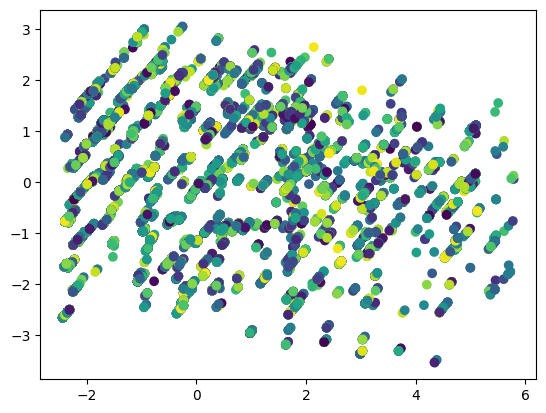

In [ ]:
colors = np.random.rand(customer_geo_pca.shape[0])
plt.scatter(customer_geo_pca[:,0], customer_geo_pca[:,1], c = colors)

#Kmeans

In [ ]:
customer_geo.head()

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Clerical,Management,Manual,Professional,Skilled Manual,Asia,Europe,North America
0,1,1,1.01,2.0,0.0,4,0,0,0,1,0,1,0,0
1,0,1,0.08,3.0,3.0,4,0,0,0,1,0,1,0,0
2,1,1,0.08,3.0,3.0,4,0,0,0,1,0,1,0,0
3,0,0,0.39,0.0,0.0,4,0,0,0,1,0,1,0,0
4,0,0,0.70,5.0,5.0,4,0,0,0,1,0,1,0,0


In [ ]:
#Xây dựng mô hình Kmeans
k     = 5
model = KMeans(n_clusters = k)
model.fit(customer_geo)  # xây dựng mô hình

KMeans(n_clusters=5)

In [ ]:
## Các trọng tâm
print(f'*** {k} trọng tâm:')
print(model.cluster_centers_)

*** 5 trọng tâm:
[[ 6.29406161e-01  5.00476342e-01  1.02732614e+00  3.24515719e+00
   3.95300095e+00  3.20990791e+00  7.58971102e-02  3.02953319e-01
   2.47697682e-02  4.70943157e-01  1.25436647e-01  2.64528422e-01
   3.15338203e-01  4.20133376e-01]
 [ 5.66945607e-01  5.03974895e-01 -7.22803347e-03  6.43096234e-01
   1.68410042e-01  4.39581590e+00  1.92050209e-01  1.63598326e-01
   3.01255230e-02  3.65271967e-01  2.48953975e-01  2.82008368e-01
   3.19037657e-01  3.98953975e-01]
 [ 3.72177955e-01  5.11620186e-01 -1.11142098e+00  1.48804781e+00
   7.30079681e-01  2.03950863e+00  2.48007968e-01 -9.79771819e-15
   6.67662683e-01  2.65604250e-02  5.77689243e-02  1.64342629e-01
   7.29747676e-01  1.05909695e-01]
 [ 6.15637652e-01  5.03036437e-01  2.34843117e-01  3.45495951e+00
   7.20900810e-01  3.67965587e+00  6.70546559e-02  3.38815789e-01
   5.06072874e-04  4.22317814e-01  1.71305668e-01  8.19838057e-02
   1.40182186e-01  7.77834008e-01]
 [ 4.91506544e-01  5.11556669e-01 -2.35611250e-01  

In [ ]:
## Kết quả gom cụm khách hàng
customer_geo['cluster'] = model.labels_
print(customer_geo.head(10))

print('\nKích thước các clusters:', Counter(model.labels_))
print('\n2 clusters lớn nhất:', Counter(model.labels_).most_common(2))

   MaritalStatus  Gender  YearlyIncome  TotalChildren  NumberChildrenAtHome  \
0              1       1          1.01            2.0                   0.0   
1              0       1          0.08            3.0                   3.0   
2              1       1          0.08            3.0                   3.0   
3              0       0          0.39            0.0                   0.0   
4              0       0          0.70            5.0                   5.0   
5              0       1          0.39            0.0                   0.0   
6              0       0          0.39            0.0                   0.0   
7              1       1          0.08            3.0                   3.0   
8              0       0          0.08            4.0                   4.0   
9              0       1          0.39            0.0                   0.0   

   Education  Clerical  Management  Manual  Professional  Skilled Manual  \
0          4         0           0       0            

In [ ]:
data = customer_geo

In [ ]:
#Xây dựng mô hình Kmeans
k     = 5
model = KMeans(n_clusters = k)
model.fit(customer_geo)  # xây dựng mô hình

KMeans(n_clusters=5)

In [ ]:
## Kết quả gom cụm khách hàng
centroids       = model.cluster_centers_
data['cluster'] = model.labels_
print(data.head(10))

print('\nKích thước các clusters:', Counter(model.labels_))
print('\nClusters lớn nhất:', Counter(model.labels_).most_common(1))

   MaritalStatus  Gender  YearlyIncome  TotalChildren  NumberChildrenAtHome  \
0              1       1          1.01            2.0                   0.0   
1              0       1          0.08            3.0                   3.0   
2              1       1          0.08            3.0                   3.0   
3              0       0          0.39            0.0                   0.0   
4              0       0          0.70            5.0                   5.0   
5              0       1          0.39            0.0                   0.0   
6              0       0          0.39            0.0                   0.0   
7              1       1          0.08            3.0                   3.0   
8              0       0          0.08            4.0                   4.0   
9              0       1          0.39            0.0                   0.0   

   Education  Clerical  Management  Manual  Professional  Skilled Manual  \
0          4         0           0       0            

#Đánh giá gom cụm

In [ ]:
!pip install scikit-learn # Install scikit-learn if you haven't already
from sklearn.metrics import silhouette_score # Import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter

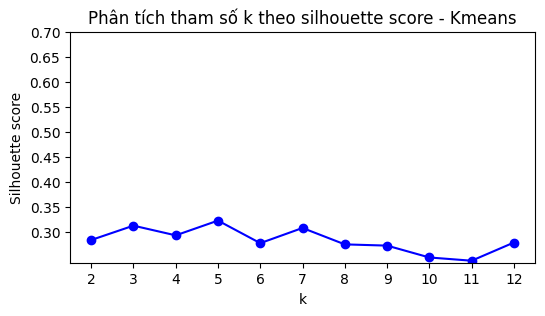

Giá trị tối ưu cho tham số: k = 5


In [ ]:
## Phân tích Silhouette scores theo giá trị của tham số k
nbClusters  = range(2, 13) # Lưu ý: (k >= 2) vì cần tính khoảng cách từ xi đến nearest cluster
silhouettes = []
for k in nbClusters:
    model = KMeans(n_clusters = k)
    model.fit(data)
    silhouettes.append(silhouette_score(data, model.fit_predict(data), metric = 'euclidean'))

plt.figure(figsize = (6, 3))
plt.plot(nbClusters, silhouettes, 'bo-')
plt.xlabel('k')
plt.xticks(nbClusters)
plt.ylabel('Silhouette score')
plt.yticks(np.arange(0.3, 0.75, 0.05))
plt.title('Phân tích tham số k theo silhouette score - Kmeans')

plt.show()
print(f'Giá trị tối ưu cho tham số: k = {nbClusters[np.argmax(silhouettes)]}')

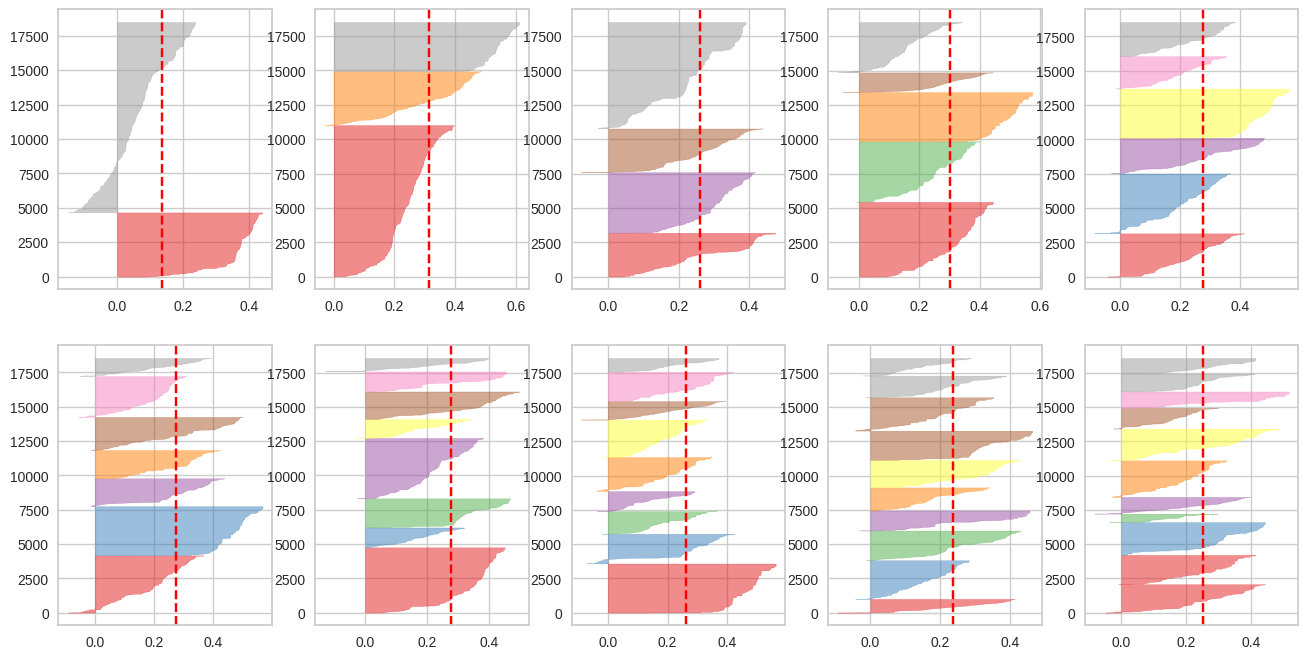

In [ ]:
## Phân tích Silhouette scores theo giá trị của tham số k
nbClusters  = range(2, 13) # Lưu ý: (k >= 2) vì cần tính khoảng cách từ xi đến nearest cluster
silhouettes = []
from yellowbrick.cluster import SilhouetteVisualizer

nbClusters = range(2, 12)
fig, ax = plt.subplots(2, 5, figsize = (16, 8)) # 2 rows, 5 cols

for k in nbClusters:
    model = KMeans(n_clusters = k)
    row, col = divmod(k - 2, 5) # tọa độ subplot

    visualizer = SilhouetteVisualizer(model, ax = ax[row][col])
    visualizer.fit(data)
## Vạch đứng đứt nét thể hiện Silouette trung bình
## Mỗi data point xi sẽ có score là vạch nằm ngang
## Những clusters có shape nhọn phía bên phải là không tốt

#HAC

In [ ]:
data = customer_geo
data.head()

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Clerical,Management,Manual,Professional,Skilled Manual,Asia,Europe,North America,cluster
0,1,1,1.01,2.0,0.0,4,0,0,0,1,0,1,0,0,3
1,0,1,0.08,3.0,3.0,4,0,0,0,1,0,1,0,0,1
2,1,1,0.08,3.0,3.0,4,0,0,0,1,0,1,0,0,1
3,0,0,0.39,0.0,0.0,4,0,0,0,1,0,1,0,0,3
4,0,0,0.70,5.0,5.0,4,0,0,0,1,0,1,0,0,1


In [ ]:
!pip install scikit-learn
from sklearn.cluster import AgglomerativeClustering # Import AgglomerativeClustering from sklearn.cluster
k     = 8
model = AgglomerativeClustering(n_clusters = k, metric = 'euclidean', linkage = 'ward')
model.fit(data[['MaritalStatus','Gender','YearlyIncome','TotalChildren','NumberChildrenAtHome', 'Education',    'Clerical', 'Management',   'Manual',   'Professional', 'Skilled Manual',   'Asia','Europe',    'North America']])
model = AgglomerativeClustering(n_clusters = k, metric = 'euclidean', linkage = 'ward')
model.fit(data[['MaritalStatus',    'Gender',   'YearlyIncome', 'TotalChildren','NumberChildrenAtHome', 'Education',    'Clerical', 'Management',   'Manual',   'Professional', 'Skilled Manual',   'Asia','Europe',    'North America']])

AgglomerativeClustering(n_clusters=8)

In [ ]:
## Kết quả gom cụm khách hàng (AgglomerativeClustering() không có trọng tâm 'cluster_centers_')
data['cluster'] = model.labels_
print(data.head(10))

   MaritalStatus  Gender  YearlyIncome  TotalChildren  NumberChildrenAtHome  \
0              1       1          1.01            2.0                   0.0   
1              0       1          0.08            3.0                   3.0   
2              1       1          0.08            3.0                   3.0   
3              0       0          0.39            0.0                   0.0   
4              0       0          0.70            5.0                   5.0   
5              0       1          0.39            0.0                   0.0   
6              0       0          0.39            0.0                   0.0   
7              1       1          0.08            3.0                   3.0   
8              0       0          0.08            4.0                   4.0   
9              0       1          0.39            0.0                   0.0   

   Education  Clerical  Management  Manual  Professional  Skilled Manual  \
0          4         0           0       0            

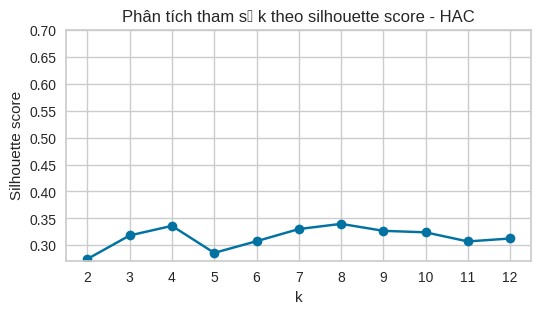

Giá trị tối ưu cho tham số: k = 8


In [ ]:
## Phân tích Silhouette scores theo giá trị của tham số k
nbClusters  = range(2, 13) # Lưu ý: (k >= 2) vì cần tính khoảng cách từ xi đến nearest cluster
silhouettes = []
for k in nbClusters:
    model = AgglomerativeClustering(n_clusters = k)
    model.fit(data)
    silhouettes.append(silhouette_score(data, model.fit_predict(data), metric = 'euclidean'))

plt.figure(figsize = (6, 3))
plt.plot(nbClusters, silhouettes, 'bo-')
plt.xlabel('k')
plt.xticks(nbClusters)
plt.ylabel('Silhouette score')
plt.yticks(np.arange(0.3, 0.75, 0.05))
plt.title('Phân tích tham số k theo silhouette score - HAC')

plt.show()
print(f'Giá trị tối ưu cho tham số: k = {nbClusters[np.argmax(silhouettes)]}')

In [ ]:
## Phân tích Silhouette scores theo giá trị của tham số k
nbClusters  = range(2, 13) # Lưu ý: (k >= 2) vì cần tính khoảng cách từ xi đến nearest cluster
silhouettes = []
from yellowbrick.cluster import SilhouetteVisualizer

nbClusters = range(2, 12)
fig, ax = plt.subplots(2, 5, figsize = (16, 8)) # 2 rows, 5 cols

for k in nbClusters:
    model = AgglomerativeClustering(n_clusters = k)
    row, col = divmod(k - 2, 5) # tọa độ subplot

    visualizer = SilhouetteVisualizer(model, ax = ax[row][col])
    visualizer.fit(data)
## Vạch đứng đứt nét thể hiện Silouette trung bình
## Mỗi data point xi sẽ có score là vạch nằm ngang
## Những clusters có shape nhọn phía bên phải là không tốt